In [1]:
cd /workspace

/workspace


In [2]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import scvi.data
import scarches.dataset 
import matplotlib.pyplot as plt
import numpy as np
import gdown
import pandas as pd

In [3]:
suffix = '600_Surg_sample_sep_train/'
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir='./figures/SCArches/'+suffix
sc.settings.set_figure_params(dpi=100, dpi_save=300,fontsize=12, frameon=False, facecolor='white', format='png', color_map='Reds')

torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
adata_SC = sc.read('data/multispecies_RATpp.h5ad')
adata_SC.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 3933 × 4242
    obs: 'sample', 'cell_types'
    var: 'gene_ids', 'Orig_VarNames'>

In [5]:
adata_SN = sc.read('data/multispecies_RAT_SN_pp.h5ad')
adata_SN.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 16815 × 3064
    obs: 'sample', 'cell_types'
    var: 'gene_ids', 'Orig_VarNames'>

In [6]:
adata_all=adata_SC.concatenate(adata_SN, batch_key='tech', batch_categories=['SC','SN'])

In [7]:
adata_all

AnnData object with n_obs × n_vars = 20748 × 992
    obs: 'sample', 'cell_types', 'tech'
    var: 'gene_ids-SC', 'Orig_VarNames-SC', 'gene_ids-SN', 'Orig_VarNames-SN'

In [8]:
set(adata_all.obs['cell_types'])

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Gabaergic Neurons',
 'Glutamatergic Neurons',
 'Microglia',
 'Neurons',
 'Oligodendrocytes',
 'Other'}

In [9]:
set(adata_all.obs['sample'])

{'IASM_9M',
 'hESgraft_12M',
 'rat11_1a',
 'rat11_2a',
 'rat11_2b',
 'rat39_3ac',
 'rat39_3b',
 'ulrich_6M'}

In [10]:
adata_pl=adata_all.copy()

In [11]:
condition_key = 'sample'
cell_type_key = 'cell_types'
target_conditions = ['ulrich_6M','IASM_9M','hESgraft_12M']

vae_epochs = 300
scanvi_epochs = 150
surgery_epochs = 600

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [12]:
set(adata_all.obs.cell_types)

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Gabaergic Neurons',
 'Glutamatergic Neurons',
 'Microglia',
 'Neurons',
 'Oligodendrocytes',
 'Other'}

In [13]:
adata_all.obs['orig_cell_types'] = adata_all.obs.cell_types
len(adata_all.obs.cell_types)

20748

In [14]:
common_cells=[]
for cell in adata_all.obs.cell_types:
    if cell.startswith('Gabaergic') or cell.startswith('Glutamatergic'):
        common_cells.append('Neurons')
    else:
        common_cells.append(cell)

print(len(common_cells), set(common_cells))

20748 {'Oligodendrocytes', 'Endothelial', 'Fibroblast', 'Neurons', 'Astrocytes', 'Microglia', 'Other'}


In [15]:
adata_all.obs.cell_types = common_cells
set(adata_all.obs.cell_types)

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Microglia',
 'Neurons',
 'Oligodendrocytes',
 'Other'}

In [16]:
set(adata_all.obs['tech'])

{'SC', 'SN'}

In [17]:
adata = adata_all.raw.to_adata()
adata.var_names_make_unique()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()


In [18]:
set(source_adata.obs.cell_types)

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Microglia',
 'Neurons',
 'Oligodendrocytes',
 'Other'}

In [19]:
set(source_adata.obs['tech'])

{'SC'}

In [20]:
set(target_adata.obs.cell_types)

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Microglia',
 'Neurons',
 'Oligodendrocytes'}

In [21]:
set(target_adata.obs['tech'])

{'SN'}

In [22]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["sample"]                                              
INFO     Using labels from adata.obs["cell_types"]                                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 3933 cells, 30730 vars, 5 batches,
         7 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [23]:
source_adata

AnnData object with n_obs × n_vars = 3933 × 30730
    obs: 'sample', 'cell_types', 'tech', 'orig_cell_types', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    uns: '_scvi'

In [24]:
set(source_adata.obs['_scvi_batch'])

{0, 1, 2, 3, 4}

In [25]:
vae = sca.models.SCANVI(
    source_adata,
    "Desconocido",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [26]:
print("Labelled Indices: ", len(vae._labeled_indices))
print("Unlabelled Indices: ", len(vae._unlabeled_indices))

Labelled Indices:  3933
Unlabelled Indices:  0


In [27]:
vae.train(
    n_epochs_unsupervised=vae_epochs,
    n_epochs_semisupervised=scanvi_epochs,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)

INFO     Training Unsupervised Trainer for 300 epochs.                                       
INFO     Training SemiSupervised Trainer for 150 epochs.                                     
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 400 epochs                                                            
Training...:  32%|███▏      | 96/300 [29:26<57:27, 16.90s/it]  INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  32%|███▏      | 96/300 [29:46<1:03:15, 18.61s/it]
INFO     Training is still 

In [28]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_types"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["sample"] = source_adata.obs[condition_key].tolist()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [29]:
reference_latent

AnnData object with n_obs × n_vars = 3933 × 10
    obs: 'cell_types', 'sample'

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
... storing 'cell_types' as categorical
... storing 'sample' as categorical


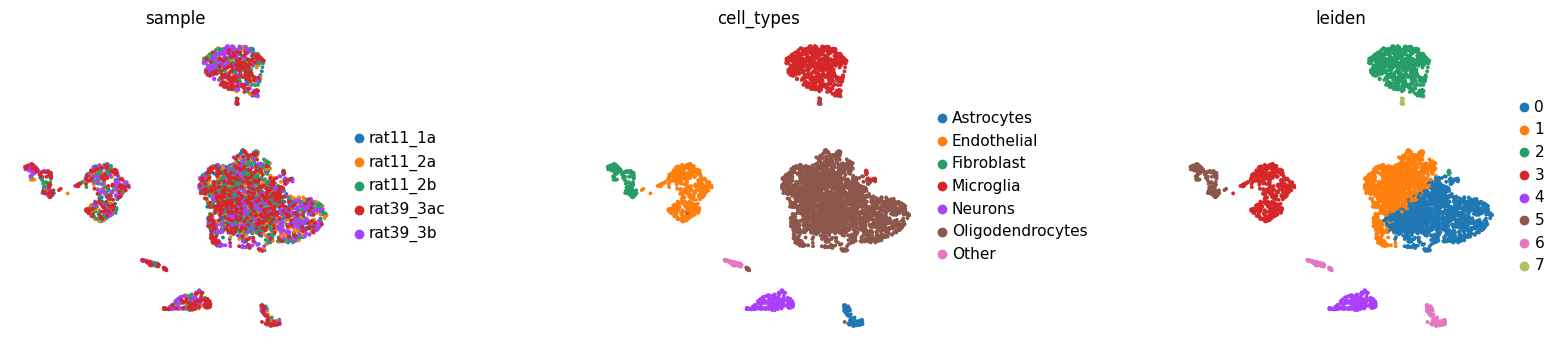

In [30]:
sc.pp.neighbors(reference_latent, n_neighbors=10)
sc.tl.leiden(reference_latent, resolution = 0.22)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=[ 'sample','cell_types', 'leiden'],
           frameon=False,
           wspace=0.6,
           save='reference_umap'
           )

In [31]:
reference_latent.obs['predictions'] = vae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_types)))

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Acc: 0.9974574116450546


In [32]:
reference_latent


AnnData object with n_obs × n_vars = 3933 × 10
    obs: 'cell_types', 'sample', 'leiden', 'predictions'
    uns: 'neighbors', 'leiden', 'umap', 'sample_colors', 'cell_types_colors', 'leiden_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [33]:
set(reference_latent.obs.predictions)


{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Microglia',
 'Neurons',
 'Oligodendrocytes',
 'Other'}

In [34]:
set(reference_latent.obs.cell_types)

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Microglia',
 'Neurons',
 'Oligodendrocytes',
 'Other'}

In [35]:
set(reference_latent.obs['sample'])

{'rat11_1a', 'rat11_2a', 'rat11_2b', 'rat39_3ac', 'rat39_3b'}

In [36]:
ref_path = 'models/celtypes_SCSN_VAE'+suffix
vae.save(ref_path, overwrite=True)

In [37]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 16815 cells, 30730 vars, 8        
         batches, 7 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Labelled Indices:  0
Unlabelled Indices:  16815


In [38]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"],
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 600 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  46%|████▌     | 275/600 [11:49:56<14:04:30, 155.91s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  46%|████▌     | 275/600 [11:52:27<14:01:59, 155.45s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Traini

In [39]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_types'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['sample'] = target_adata.obs[condition_key].tolist()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
... storing 'cell_types' as categorical
... storing 'sample' as categorical


<Figure size 400x400 with 0 Axes>

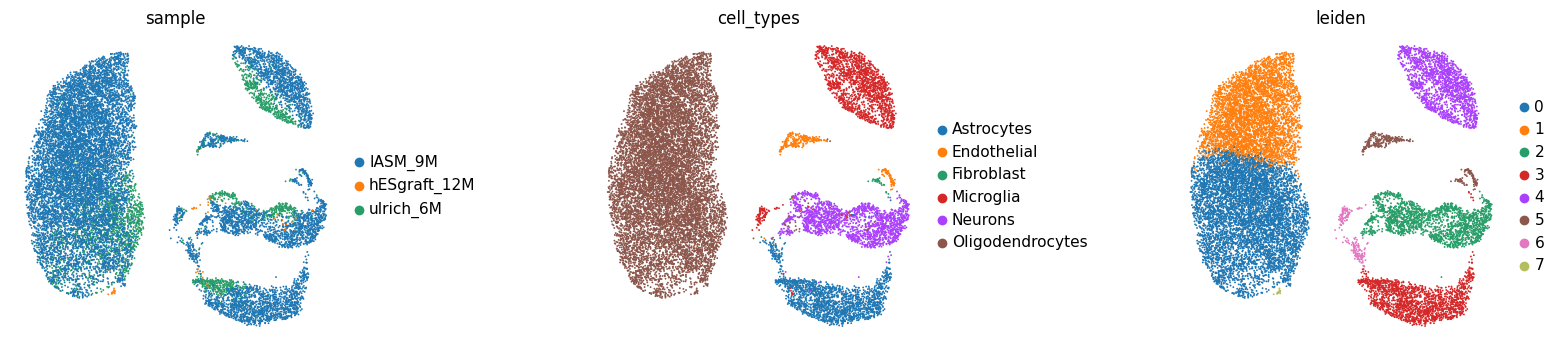

In [40]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent, resolution=0.22)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["sample", "cell_types", 'leiden'],
    frameon=False,
    wspace=0.6,
    save='UMAP_query')

In [41]:
surgery_path = ref_path+'/surgery_model'
model.save(surgery_path, overwrite=True)

In [42]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.cell_types)))

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Acc: 0.9647933392804044


In [43]:
set(query_latent.obs.cell_types)

{'Astrocytes',
 'Endothelial',
 'Fibroblast',
 'Microglia',
 'Neurons',
 'Oligodendrocytes'}

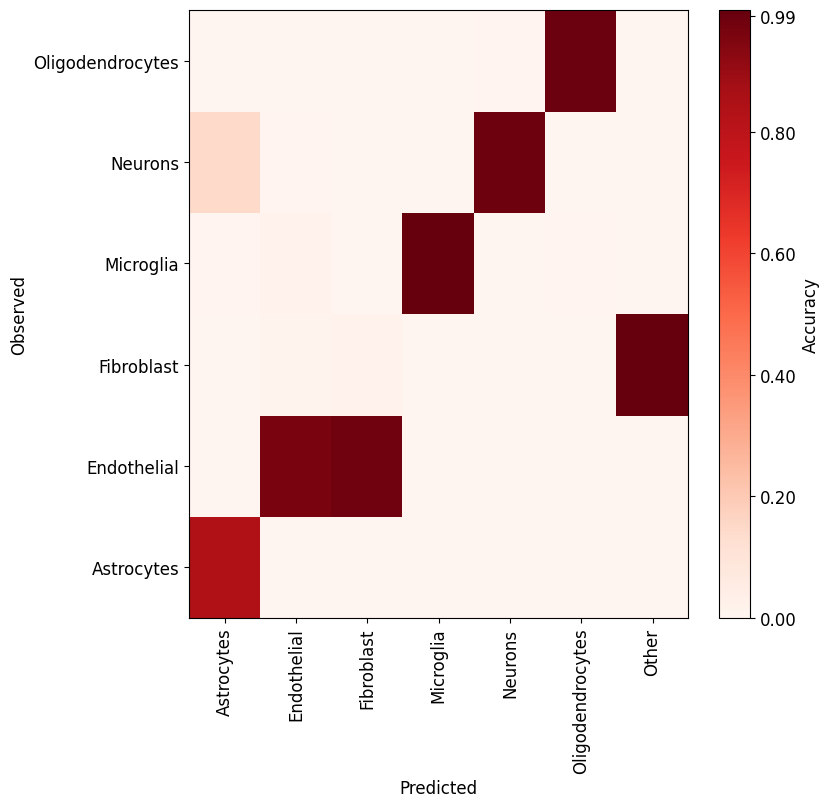

In [44]:
df = query_latent.obs.groupby(["cell_types", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.colorbar(label='Accuracy', ticks=[0,0.2,0.4,0.6,0.8,0.99])
plt.savefig('./figures/SCArches/'+suffix+'accuracies.png') 

In [50]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_types'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['orig_cell_types'] = adata_full.obs['orig_cell_types'].tolist()
full_latent.obs['sample'] = adata_full.obs[condition_key].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 20748 cells, 30730 vars, 8        
         batches, 7 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
... storing 'cell_types' as categorical
... storing 'orig_cell_types' as categorical
... storing 'sample' as categorical


<Figure size 400x400 with 0 Axes>

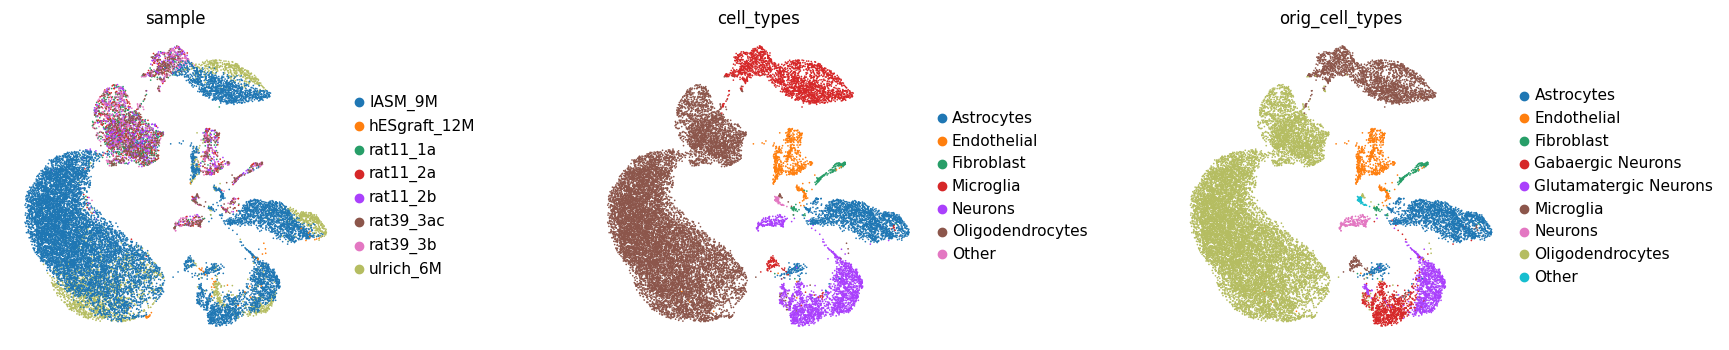

In [51]:

sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent, resolution= 0.22)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["sample", "cell_types","orig_cell_types"],
    frameon=False,
    wspace=0.6,
    save="UMAP_Full"
)

In [52]:
full_latent.obs['predictions'] = model.predict(adata=adata_full)
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.cell_types)))

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Acc: 0.9709851551956815


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
... storing 'predictions' as categorical


<Figure size 400x400 with 0 Axes>

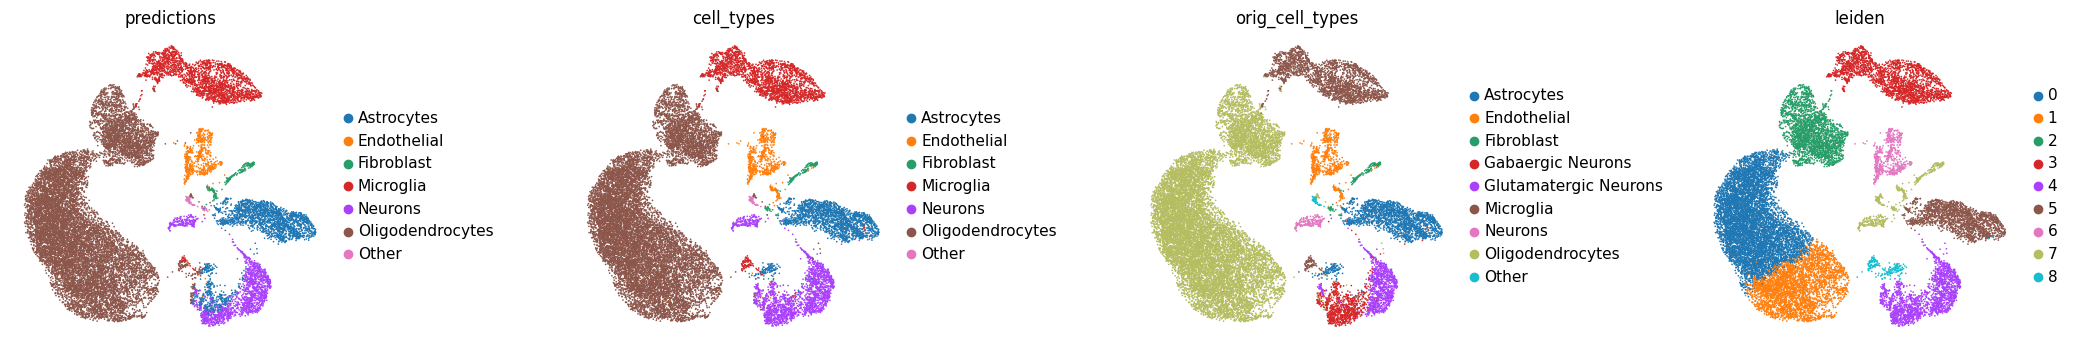

In [53]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent, resolution = 0.22)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["predictions", "cell_types",'orig_cell_types', "leiden"],
    frameon=False,
    wspace=0.6,
    save='UMAP_Combined'
)

In [54]:
full_latent.write('data/full_latent_celltypes_SCSN_sample.h5ad')